<h1 style="text-align: center;font-size: 58px;">NURSERY</h1>
Il <em>Nursery Database</em> è stato derivato da un modello decisionale gerarchico originariamente sviluppato per classificare le domande di ammissione agli asili. È stato utilizzato per diversi anni negli anni ’80, quando a Lubiana, in Slovenia, vi era un’eccessiva richiesta di iscrizione a questi asili, e spesso le domande rifiutate richiedevano una spiegazione oggettiva.
<p>La decisione finale dipendeva da tre sottoproblemi:</p>
<ul>
  <li>Occupazione dei genitori e presenza dell’asilo per il bambino,</li>
  <li>Struttura familiare e situazione finanziaria,</li>
  <li>Quadro sociale e sanitario della famiglia.</li>
</ul>

<p>Il modello gerarchico classifica le domande di ammissione agli asili secondo la seguente struttura concettuale:</p>


<ul>
  <li><strong style="display:inline-block; margin-top:10px; margin-bottom:10px;">EMPLOY</strong> – Occupazione dei genitori e dell'asilo nido del bambino
    <ul>
        <li>parents – Professione dei genitori</li>
        <ul>
            <li>Valori unici: usual, pretentious, great_pret</li>
        </ul>
      <li>has_nurs – Asilo nido</li>
        <ul>
            <li>Valori unici: proper, less_proper, improper, critical, very_crit</li>
        </ul>
    </ul>
  </li>

  <li><strong style="display:inline-block; margin-top:10px; margin-bottom:10px;">STRUCT_FINAN</strong> – Struttura familiare e situazione finanziaria
    <ul>
      <li>form – Forma della famiglia</li>
        <ul>
            <li>Valori unici: complete, completed, incomplete, foster</li>
        </ul>
      <li>children – Numero di figli</li>
        <ul>
            <li>Valori unici: 1, 2, 3, more</li>
        </ul>
      <li>housing – Condizioni abitative</li>
        <ul>
            <li>Valori unici: convenient, less_conv, critical</li>
        </ul>
      <li>finance – Situazione finanziaria della famiglia</li>
        <ul>
            <li>Valori unici: convenient, inconv</li>
        </ul>
    </ul>
  </li>

  <li><strong style="display:inline-block; margin-top:10px; margin-bottom:10px;">SOC_HEALTH</strong> – Quadro sociale e sanitario della famiglia
    <ul>
      <li>social – Condizioni sociali</li>
        <ul>
            <li>Valori unici: nonprob, slightly_prob, problematic</li>
        </ul>
      <li>health – Condizioni sanitarie</li>
        <ul>
            <li>Valori unici: recommended, priority, not_recom</li>
        </ul>
    </ul>
  </li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

<h1>Funzione per l'utilizzo dei classificatori</h1>
<p>Abbiamo implementato una funzione che prende in input il modello di classificazione, le divisioni in <strong>train</strong> e <strong>test</strong> del dataset, diviso in <strong>X</strong> e <strong>y</strong>, e il nome del modello. La funzione svolge diversi compiti:</p>
<ul>
     <div style="margin-top: 1em;"><li><h3>Addestramento:</h3></li></div>
        <ul>
            <li>Addestra il modello utilizzando le <strong>X_train</strong> e <strong>y_train</strong></li>
        </ul>
     <div style="margin-top: 1em;"><li><h3>Predizione:</h3></li></div>
        <ul>
            <li>Predice le classi per i due gruppi <strong>y_train</strong> e <strong>y_test</strong>, e in più viene calcolata <strong>y_pred_proba</strong>, che indica la probabilità di appartenere a ciascuna classe</li>
        </ul>
    <div style="margin-top: 1em;"><li><h3>Metriche su train e test:</h3></li></div>
        <ul>
            <li>Accuracy - percentuale di predizioni corrette: $$\frac{TP + TN}{TP + TN + FP + FN}$$</li>
            <li>Precision - quante delle previsioni positive sono corrette: $$\frac{TP}{TP + FP}$$</li>
            <li>Recall - quante delle vere istanze sono state correttamente trovate: $$\frac{TP}{TP + FN}$$</li>
            <li>F1-Score - meida armonica fra Precision e Recall: $$ 2 \cdot \frac{Precision  \cdot Recall}{Precision + Recall}$$</li>
        </ul>
Per le ultime tre metriche abbiamo applicato la meida pesata, <em>weighted</em>, perchè migliora la stabilità quando ci sono classi sbilanciate, essendo che la classe 2 ha solo un elemento difficilmente prevedibile.
    <div style="margin-top: 1em;"><li><h3>Matrice di confusione:</h3></li></div>
        <ul>
            <li>Costruisce una matrice che confronta la classe reale e la classe predetta per ciascun valore</li>
        </ul>
    <div style="margin-top: 1em;"><li><h3>Output:</h3></li></div>
        <ul>
            <li>Dataframe che contiene i valori ricavati dalle metriche per train e test</li>
            <li>Matrice di confusione in scala di blu</li>
            <li>Dataframe che mostra la classe corretta, classe predetta e probabilità di appartenere ad ogni classe per ogni elemento. Inoltre, viene visualizzata nello specifico la riga che contiene l'unico elemento della classe 2</li>
        <ul>
</ul>

In [2]:
def evaluate_and_plot(model, X_train, y_train, X_test, y_test, name = "Modello"):
    # Addestramento
    model.fit(X_train, y_train)
    
    # Predizione
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Metriche
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    prec_train = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
    prec_test = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)

    rec_train = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
    rec_test = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)

    f1_train = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_test = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    
    # Matrice di confuzione
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Stampa risultati
    scores_dict = {
                   'Training Set': [acc_train, prec_train, rec_train, f1_train],
                   'Test Set': [acc_test, prec_test, rec_test, f1_test]}
    scores = pd.DataFrame(scores_dict, index=['Accuracy', 'Precision', 'Recall', 'F1-score'])
    display(scores)
    
    # Visualizza matrice di confusione
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = 'Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.grid(False)
    plt.show()

    y_pred_df = pd.DataFrame({
                          'True Class': y_test,
                          'Pred. Class': y_pred_test, 
                          'P(Class 0) - %': np.round(y_pred_proba[:, 0] * 100, decimals=2), 
                          'P(Class 1) - %': np.round(y_pred_proba[:, 1] * 100, decimals=2), 
                          'P(Class 2) - %': np.round(y_pred_proba[:, 2] * 100, decimals=2),
                          'P(Class 3) - %': np.round(y_pred_proba[:, 3] * 100, decimals=2),
                          'P(Class 4) - %': np.round(y_pred_proba[:, 4] * 100, decimals=2)})
    display(y_pred_df)

    display(y_pred_df[y_pred_df['True Class'] == 2])

    return acc_train,acc_test

# Importazione dei dati e creazione del dataframe

In [3]:
nursery = fetch_ucirepo(id=76) 

X = nursery.data.features 
y = nursery.data.targets

In [4]:
nursery_dataframe = pd.concat([X, y], axis=1)

display(nursery_dataframe)

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


<h1>One-hot encoding</h1>
I dati ora sono salvati nelle variabili <strong>X</strong> e <strong>y</strong>.
A questo punto abbiamo effettuato il <strong>Label encoding</strong>, trasformando le etichette delle classi contenute nella  variabile <strong>target</strong> in interi.
Il passaggio successivo è stato il <strong>One-hot encoding</strong>, che trasforma ogni colonna categorica in un insieme di colonne binarie, una per ogni valore unico. La dimesione del dataframe aumenta così a 28 colonne, ma in questo modo facciamo sì che la PCA possa lavorare sui dati, essendo ora numerici

In [5]:
# Copia del dataframe originale
nursery_dataframe_old = nursery_dataframe.copy()
onehot_cols = nursery_dataframe.columns.to_list()[:-1]

#Label encoding
labelenc_class = LabelEncoder()
labelenc_class.fit(nursery_dataframe['class'].values)
nursery_dataframe['class'] = labelenc_class.transform(nursery_dataframe['class'].values)

# One-hot encoding
nursery_dataframe = pd.get_dummies(nursery_dataframe, columns=onehot_cols)

# Crea un DataFrame con le corrispondenze
mapping_df = pd.DataFrame({
    'Etichetta originale': labelenc_class.classes_,
    'Valore numerico': labelenc_class.transform(labelenc_class.classes_)
})

# Mostra il risultato
display(mapping_df.style.hide(axis="index"))
    
display(nursery_dataframe)

Etichetta originale,Valore numerico
not_recom,0
priority,1
recommend,2
spec_prior,3
very_recom,4


,class,parents_great_pret,parents_pretentious,parents_usual,has_nurs_critical,has_nurs_improper,has_nurs_less_proper,has_nurs_proper,has_nurs_very_crit,form_complete,...,housing_critical,housing_less_conv,finance_convenient,finance_inconv,social_nonprob,social_problematic,social_slightly_prob,health_not_recom,health_priority,health_recommended
0,2,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,False,False,True
1,1,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,False,True,False
2,0,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
3,2,False,False,True,False,False,False,True,False,True,...,False,False,True,False,False,False,True,False,False,True
4,1,False,False,True,False,False,False,True,False,True,...,False,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12955,3,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,False,True,False,True,False
12956,0,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,False,True,True,False,False
12957,3,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,True,False,False,False,True
12958,3,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,True,False,False,True,False


In [6]:
X = nursery_dataframe.iloc[:,1:].values
y = nursery_dataframe['class'].values

<h1>Suddivisione del dataset</h1>
Settiamo il seed in modo da rendere replicabile la stessa operazione ogni volta che viene ricaricato il codice.
<p>A queto punto utilizziamo la funzione <em>train_test_split()</em> di  sklearn per suddividere il set in <strong>X_train</strong> e <strong>X_test</strong> e le loro rispettive <strong>y</strong>. La percentuale di dati che devono appartenere al set di test è indicata dalla variabile <em>test_p</em>, mentre <em>stratify</em> garantisce che la distribuzione delle classi rimanga proporzionale in train e test.</p>

In [7]:
random_state = 42

test_p = 0.5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_p, random_state=random_state, shuffle=True, stratify = y)

display(pd.DataFrame({'X_train': X_train.shape, 'X_test': X_test.shape}, index=['N. sanmples', 'N.features']))

# Calcolo della distribuzione delle classi nel test set
class_distribution = pd.Series(y_test).value_counts().sort_index()

# Creazione del DataFrame
distribution_df = pd.DataFrame({
    'Classe': class_distribution.index,
    'Conteggio': class_distribution.values
})

# Decodifica delle classi (se vuoi i nomi originali)
distribution_df['Classe'] = labelenc_class.inverse_transform(distribution_df['Classe'])

# Visualizzazione senza indici
display(distribution_df.style.hide(axis='index'))

,X_train,X_test
N. sanmples,6480,6480
N.features,27,27


Classe,Conteggio
not_recom,2160
priority,2133
recommend,1
spec_prior,2022
very_recom,164


# PCA

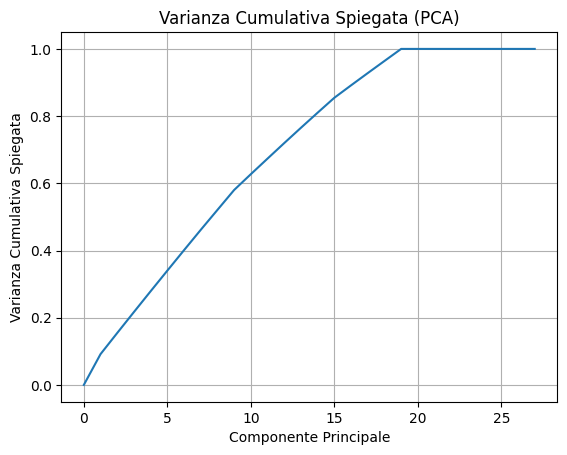

Numero di componenti principali selezionate: 19


In [8]:
# Inizializzazione oggetto PCA
pca = PCA(19)

# "Fit" dell'oggetto PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# PCA per il grafico
pca_graph = PCA()
pca_graph.fit(X_train)
pca_3 = PCA(3)
pca_3.fit(X_train)

varianza_spiegata = pca_3.explained_variance_ratio_
varianza_totale = varianza_spiegata.sum()

# Calcoliamo la varianza spiegata cumulativa
expld_variance = np.insert(np.cumsum(pca_graph.explained_variance_ratio_), 0, 0)

# Creiamo il grafico della varianza cumulativa
plt.figure()
plt.plot(expld_variance)
plt.title('Varianza Cumulativa Spiegata (PCA)')
plt.xlabel('Componente Principale')
plt.ylabel('Varianza Cumulativa Spiegata')

plt.grid()
plt.show()
print(f"Numero di componenti principali selezionate: {pca.n_components_}")

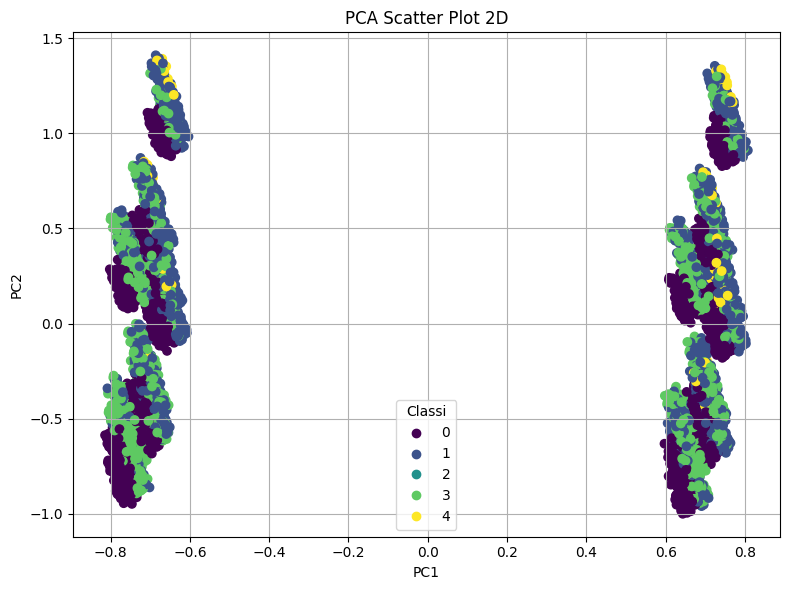

Le prime 2 PC spiegano il 15.46% della varianza


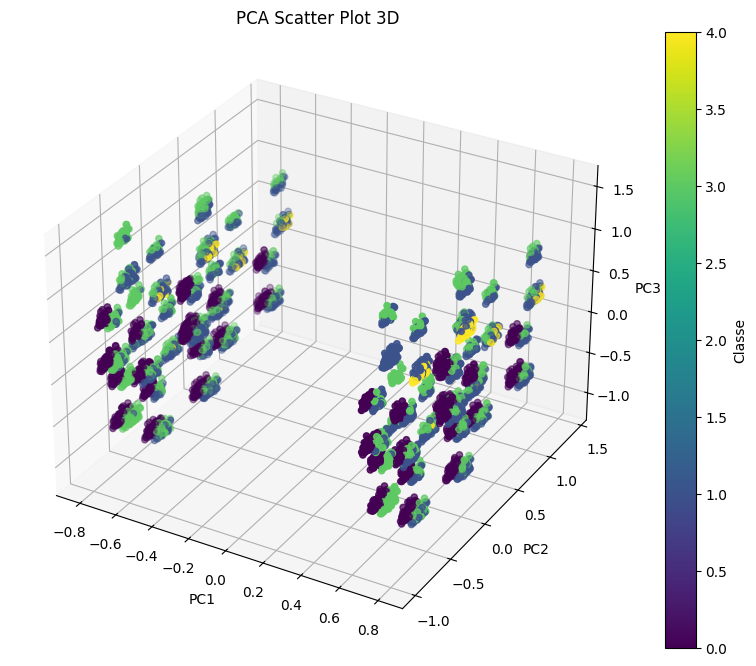

Le prime 3 PC spiegano il 21.70% della varianza


In [9]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c = y_train)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter Plot 2D")
plt.legend(*scatter.legend_elements(), title="Classi")
plt.grid(True)
plt.tight_layout()
plt.show()
print(f"Le prime 2 PC spiegano il {varianza_spiegata[0]*100+varianza_spiegata[1]*100:.2f}% della varianza")

# Grafico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c = y_train)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA Scatter Plot 3D")
plt.colorbar(scatter, label="Classe")
plt.show()
print(f"Le prime 3 PC spiegano il {varianza_totale*100:.2f}% della varianza")

# Barplot


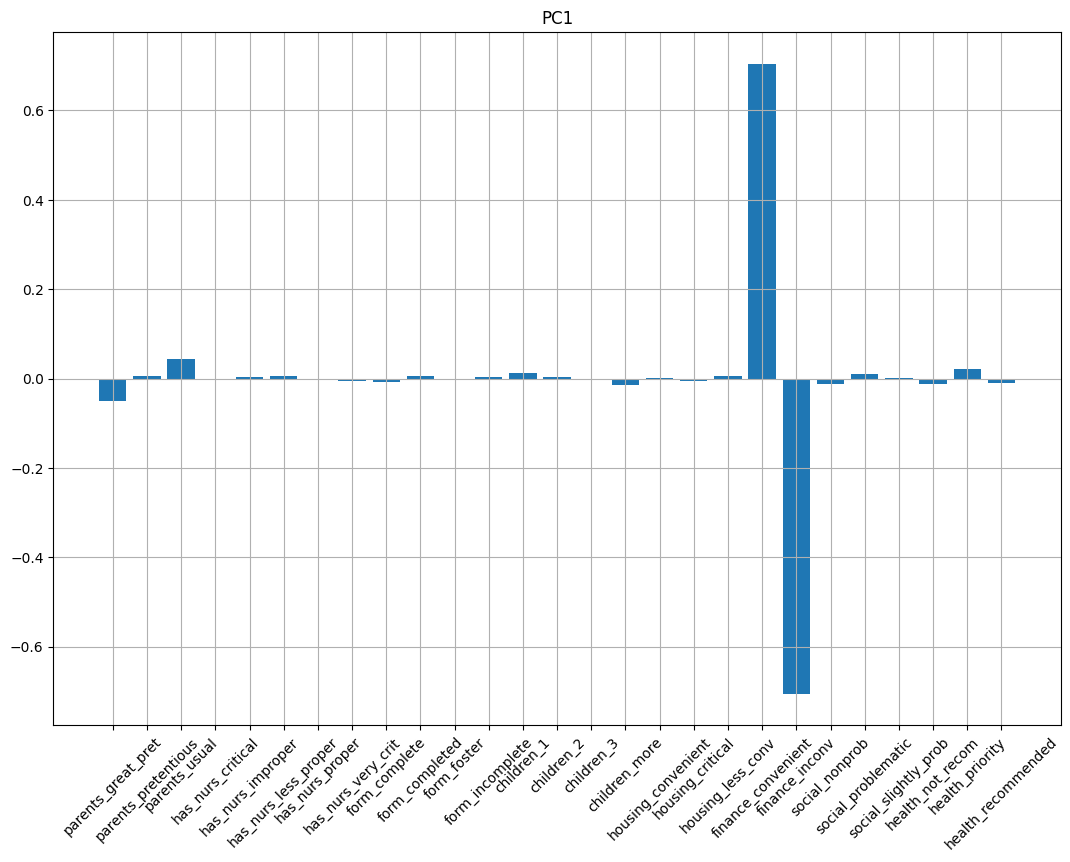

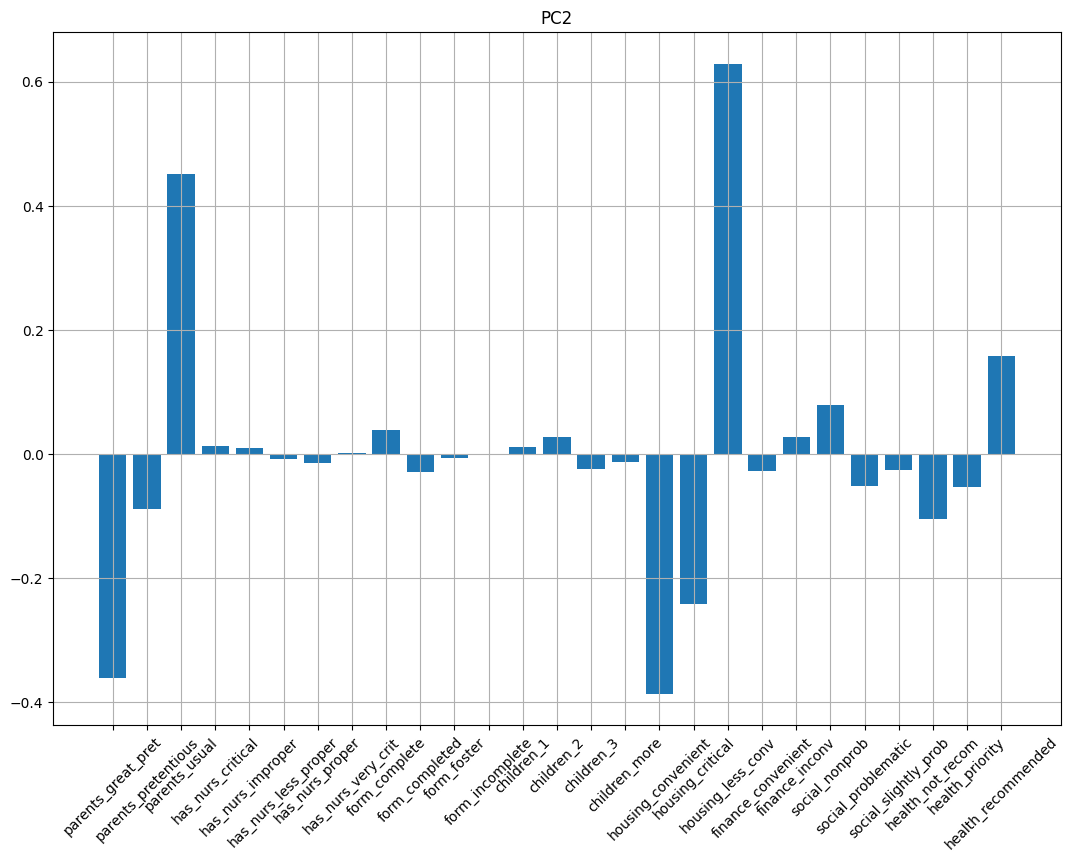

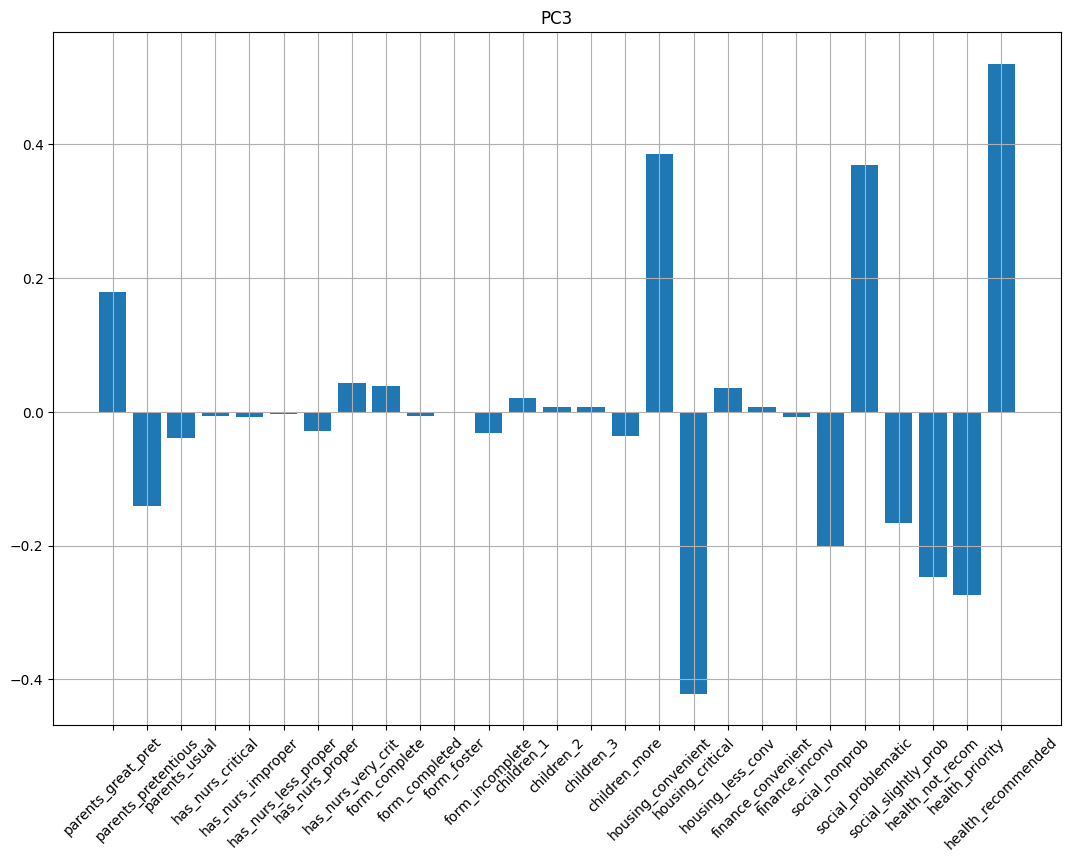

In [10]:
plt.figure(figsize = (13,9))
plt.bar(np.arange(len(pca.components_[0])), pca.components_[0,:])
plt.xticks(ticks = np.arange(len(pca.components_[0])),
           labels = nursery_dataframe.columns.to_list()[1:],
           rotation = 45)
plt.title("PC1")
plt.grid()
plt.show()

plt.figure(figsize = (13,9))
plt.bar(np.arange(len(pca.components_[0])), pca.components_[1,:])
plt.xticks(ticks = np.arange(len(pca.components_[0])),
           labels = nursery_dataframe.columns.to_list()[1:],
           rotation = 45)
plt.title("PC2")
plt.grid()
plt.show()

plt.figure(figsize = (13,9))
plt.bar(np.arange(len(pca.components_[0])), pca.components_[2,:])
plt.xticks(ticks = np.arange(len(pca.components_[0])),
           labels = nursery_dataframe.columns.to_list()[1:],
           rotation = 45)
plt.title("PC3")
plt.grid()
plt.show()

# Loading Graph

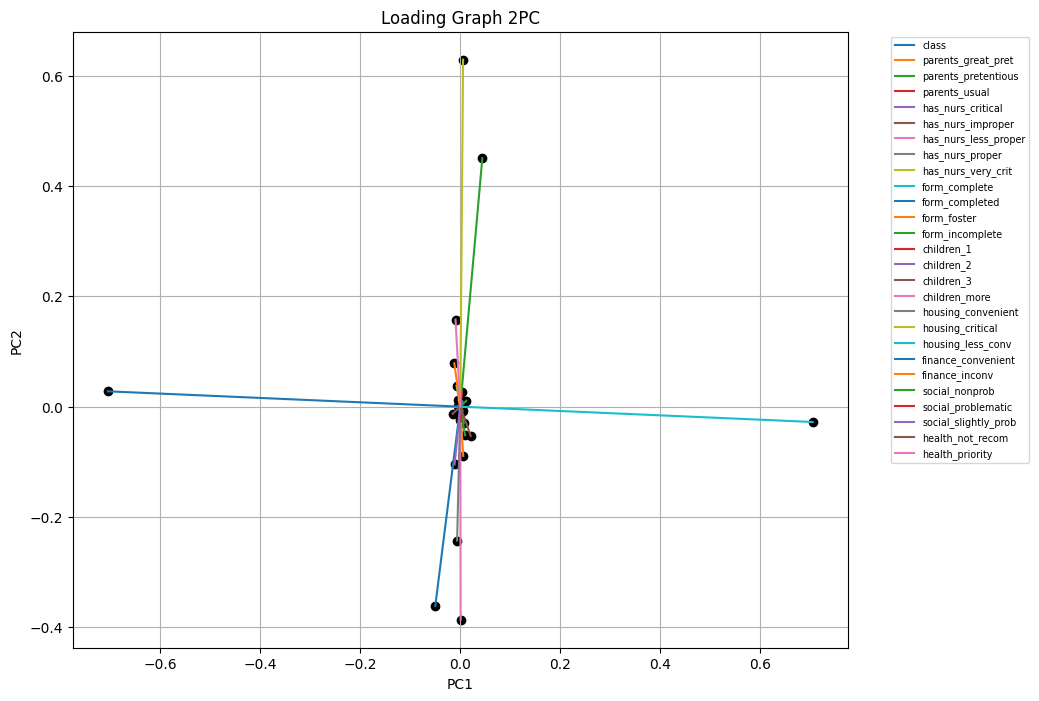

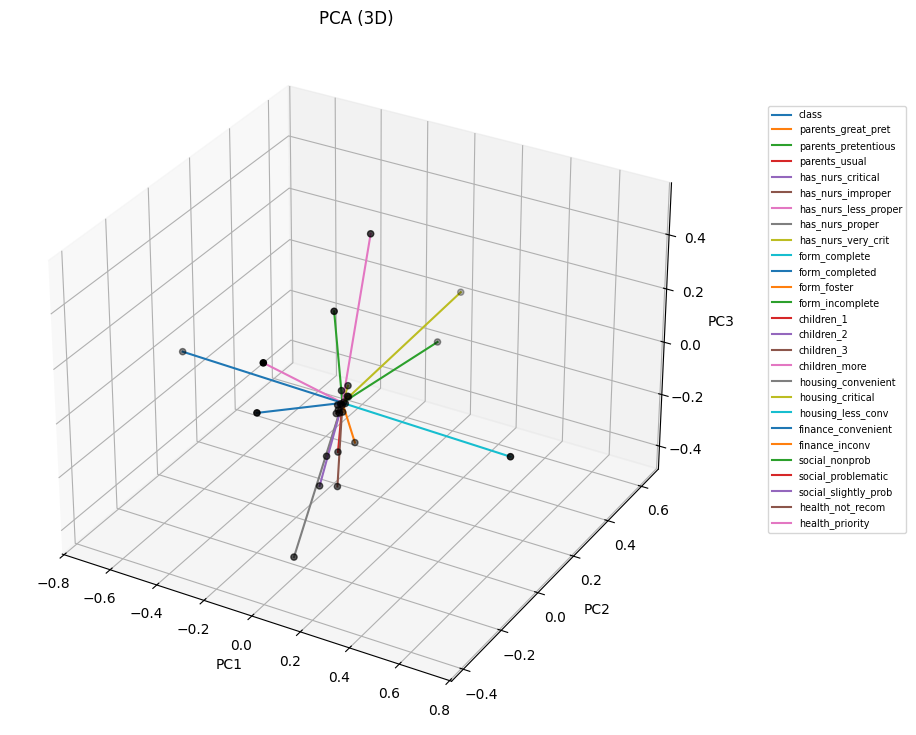

In [11]:
plt.figure(figsize = (10,8))
for i in range(len(pca.components_[0])):
    plt.plot([0,pca.components_[0,i]],[0,pca.components_[1,i]],label = nursery_dataframe.columns.to_list()[i])

plt.scatter(pca.components_[0,:], pca.components_[1,:], c = 'k')
plt.legend(bbox_to_anchor = (1.05,1), fontsize = 'x-small')
plt.title("Loading Graph 2PC")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()


fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(pca.components_[0])):
    ax.plot([0,pca.components_[0,i]],[0,pca.components_[1,i]],[0,pca.components_[2,i]],label = nursery_dataframe.columns.to_list()[i])
ax.scatter(pca.components_[0,:], pca.components_[1,:], pca.components_[2,:], c = 'k')
ax.legend(bbox_to_anchor = (1.3,0.9), fontsize = 'x-small')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA (3D)")
plt.grid()
plt.show()

# Grafico LDA 2D su dati originali e su dati PCA-ridotti #

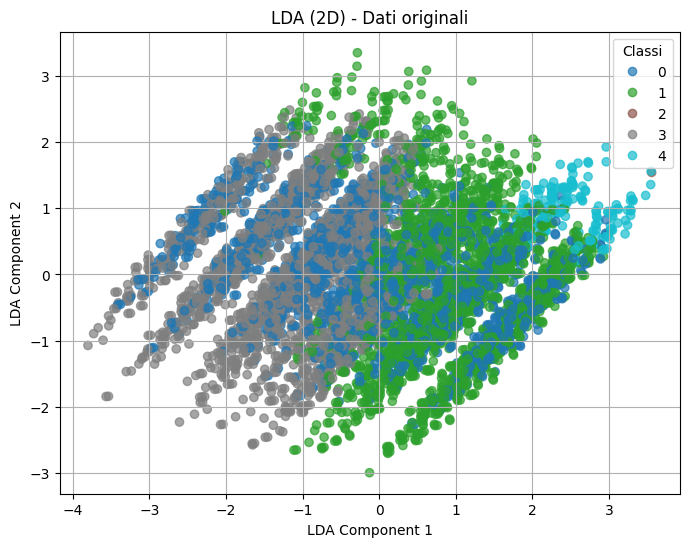

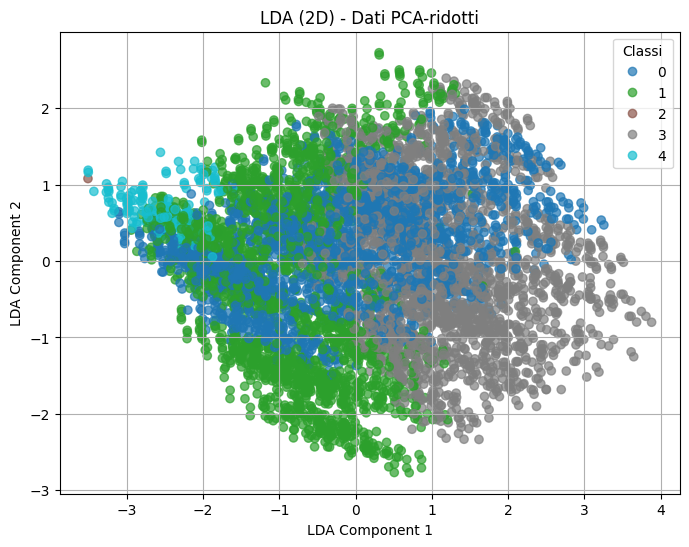

In [12]:
lda_vis = LDA(n_components=2)
X_lda_2d = lda_vis.fit_transform(X_train, y_train)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lda_2d[:, 0], X_lda_2d[:, 1], c=y_train, cmap='tab10', alpha=0.7)
plt.title("LDA (2D) - Dati originali")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.legend(*scatter.legend_elements(), title="Classi")
plt.grid(True)
plt.show()

lda_vis_pca = LDA(n_components=2)
X_lda_2d_pca = lda_vis_pca.fit_transform(X_train_pca, y_train)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lda_2d_pca[:, 0], X_lda_2d_pca[:, 1], c=y_train, cmap='tab10', alpha=0.7)
plt.title("LDA (2D) - Dati PCA-ridotti")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.legend(*scatter.legend_elements(), title="Classi")
plt.grid(True)
plt.show()

# Grafici LDA 3D su dati originali e su dati PCA-ridotti #

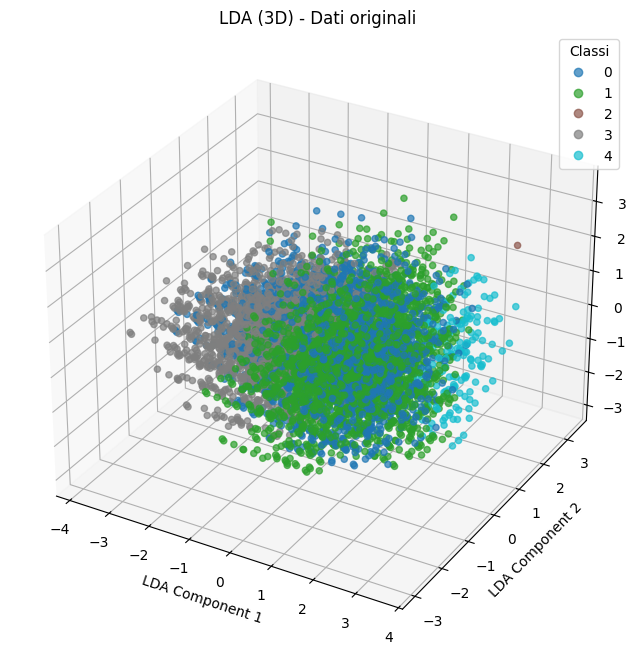

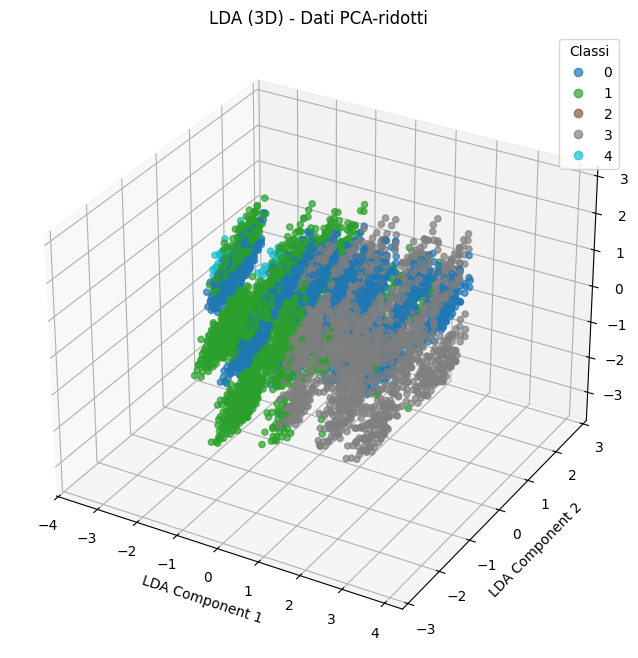

In [13]:
lda_3d = LDA(n_components=3)
X_lda_3d = lda_3d.fit_transform(X_train, y_train)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_lda_3d[:, 0], X_lda_3d[:, 1], X_lda_3d[:, 2], 
                     c=y_train, cmap='tab10', alpha=0.7)
ax.set_title("LDA (3D) - Dati originali")
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
legend = ax.legend(*scatter.legend_elements(), title="Classi", loc="best")
plt.show()

lda_3d_pca = LDA(n_components=3)
X_lda_3d_pca = lda_3d_pca.fit_transform(X_train_pca, y_train)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_lda_3d_pca[:, 0], X_lda_3d_pca[:, 1], X_lda_3d_pca[:, 2], 
                     c=y_train, cmap='tab10', alpha=0.7)
ax.set_title("LDA (3D) - Dati PCA-ridotti")
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
legend = ax.legend(*scatter.legend_elements(), title="Classi", loc="best")
plt.show()

# LDA come classificatore

,Training Set,Test Set
Accuracy,0.541512,0.550617
Precision,0.533220,0.541889
Recall,0.541512,0.550617
F1-score,0.528887,0.537836


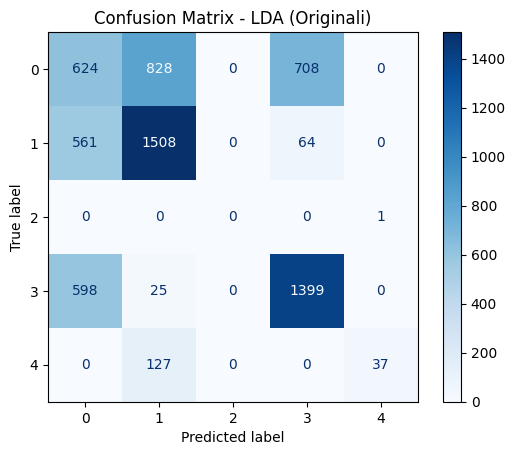

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,43.25,18.20,0.0,38.51,0.05
1,0,3,35.93,13.27,0.0,50.79,0.01
2,1,1,42.13,43.76,0.0,13.87,0.25
3,3,3,20.01,2.84,0.0,77.14,0.00
4,1,3,32.78,7.45,0.0,59.72,0.06
...,...,...,...,...,...,...,...
6475,0,3,10.12,0.63,0.0,89.25,0.00
6476,0,3,37.89,10.65,0.0,51.43,0.02
6477,1,0,46.35,34.18,0.0,19.11,0.36
6478,0,0,44.40,35.89,0.0,19.65,0.06


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,1.37,17.58,5.55,0.02,75.48


,Training Set,Test Set
Accuracy,0.567438,0.571142
Precision,0.559307,0.565696
Recall,0.567438,0.571142
F1-score,0.556254,0.560160


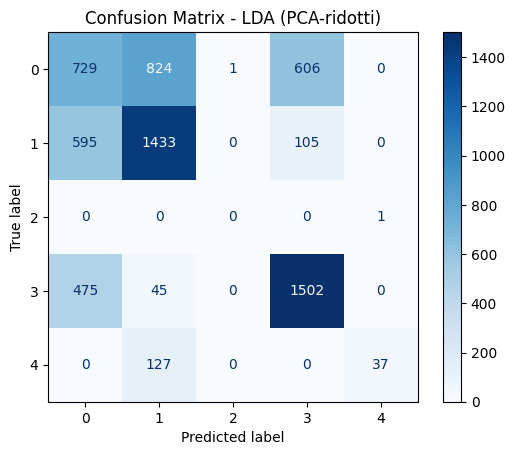

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,44.42,22.13,0.0,33.34,0.11
1,0,3,37.60,16.75,0.0,45.63,0.01
2,1,1,37.53,47.24,0.0,14.97,0.27
3,3,3,20.97,2.81,0.0,76.22,0.00
4,1,0,47.08,5.86,0.0,47.01,0.05
...,...,...,...,...,...,...,...
6475,0,3,13.11,0.86,0.0,86.04,0.00
6476,0,3,39.13,13.71,0.0,47.10,0.06
6477,1,0,62.50,23.90,0.0,13.36,0.25
6478,0,0,43.80,40.36,0.0,15.73,0.12


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,3.81,17.15,5.41,0.01,73.62


In [14]:
lda = LDA()

[LDA_score, LDA_score_test] = evaluate_and_plot(lda, X_train, y_train, X_test, y_test, name = "LDA (Originali)")
[LDA_score_PCA, LDA_score_test_PCA] = evaluate_and_plot(lda, X_train_pca, y_train, X_test_pca, y_test, name = "LDA (PCA-ridotti)")

# SVM

Non posso usare la Gridsearch perchè una classe ha solo un valore

,Training Set,Test Set
Accuracy,0.930710,0.933796
Precision,0.930464,0.933378
Recall,0.930710,0.933796
F1-score,0.930550,0.933517


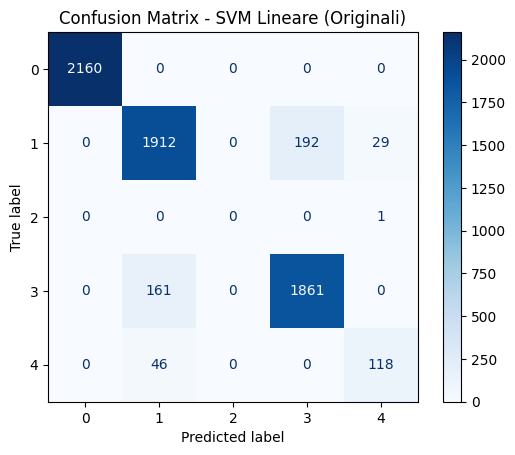

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,99.90,0.03,0.01,0.05,0.02
1,0,0,99.90,0.02,0.02,0.05,0.02
2,1,1,0.03,91.44,0.02,8.51,0.01
3,3,3,0.02,0.19,0.01,99.78,0.00
4,1,3,0.03,1.82,0.02,98.14,0.00
...,...,...,...,...,...,...,...
6475,0,0,99.90,0.02,0.01,0.05,0.02
6476,0,0,99.91,0.02,0.01,0.05,0.02
6477,1,1,0.08,71.93,0.07,25.19,2.73
6478,0,0,99.89,0.04,0.01,0.04,0.02


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.21,0.08,0.48,0.03,99.2


,Training Set,Test Set
Accuracy,0.931481,0.933796
Precision,0.931253,0.933378
Recall,0.931481,0.933796
F1-score,0.931311,0.933517


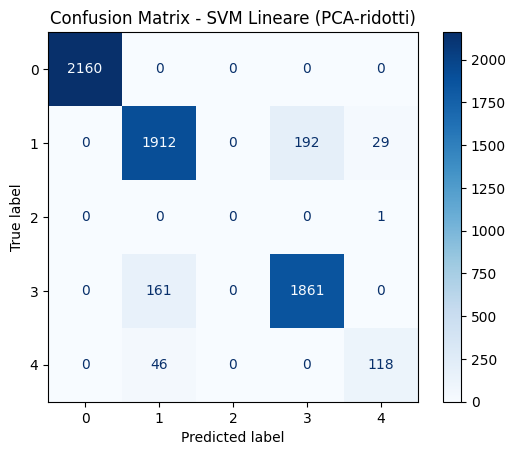

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,99.90,0.03,0.01,0.05,0.02
1,0,0,99.90,0.02,0.02,0.05,0.02
2,1,1,0.03,91.44,0.02,8.51,0.01
3,3,3,0.02,0.19,0.01,99.78,0.00
4,1,3,0.03,1.82,0.02,98.14,0.00
...,...,...,...,...,...,...,...
6475,0,0,99.90,0.02,0.01,0.05,0.02
6476,0,0,99.91,0.02,0.01,0.05,0.02
6477,1,1,0.08,71.93,0.07,25.18,2.73
6478,0,0,99.89,0.04,0.01,0.04,0.02


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.21,0.08,0.48,0.03,99.2


In [15]:
svc_linear = SVC(kernel='linear', C = 2, probability=True, random_state = 42)

[SVMl_score, SVMl_score_test] = evaluate_and_plot(svc_linear, X_train, y_train, X_test, y_test, name = "SVM Lineare (Originali)")
[SVMl_score_PCA, SVMl_score_test_PCA] = evaluate_and_plot(svc_linear, X_train_pca, y_train, X_test_pca, y_test, name = "SVM Lineare (PCA-ridotti)")

,Training Set,Test Set
Accuracy,0.999846,0.999846
Precision,0.999692,0.999692
Recall,0.999846,0.999846
F1-score,0.999769,0.999769


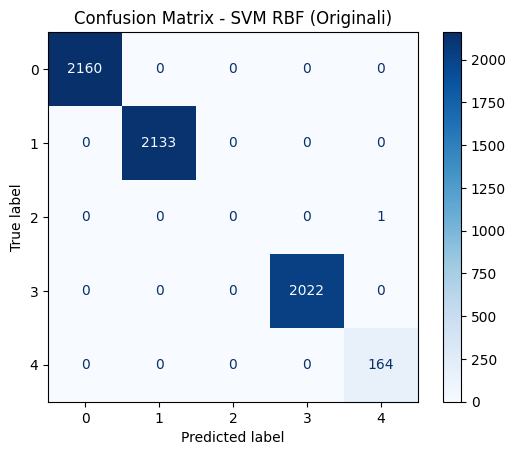

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,99.90,0.02,0.01,0.05,0.02
1,0,0,99.89,0.02,0.02,0.05,0.02
2,1,1,0.00,99.99,0.01,0.00,0.00
3,3,3,0.00,0.00,0.00,100.00,0.00
4,1,1,0.00,99.93,0.01,0.06,0.00
...,...,...,...,...,...,...,...
6475,0,0,99.90,0.02,0.01,0.05,0.02
6476,0,0,99.90,0.02,0.02,0.05,0.02
6477,1,1,0.00,99.83,0.02,0.16,0.00
6478,0,0,99.90,0.05,0.02,0.02,0.02


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.1,0.07,1.27,0.14,98.42


,Training Set,Test Set
Accuracy,0.999846,0.999846
Precision,0.999692,0.999692
Recall,0.999846,0.999846
F1-score,0.999769,0.999769


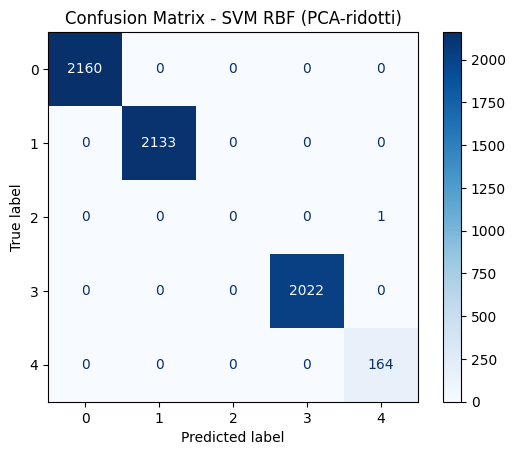

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,99.90,0.02,0.02,0.05,0.02
1,0,0,99.89,0.02,0.02,0.05,0.02
2,1,1,0.00,99.98,0.01,0.00,0.00
3,3,3,0.00,0.00,0.00,100.00,0.00
4,1,1,0.00,99.93,0.01,0.06,0.00
...,...,...,...,...,...,...,...
6475,0,0,99.90,0.02,0.01,0.05,0.02
6476,0,0,99.90,0.02,0.02,0.05,0.02
6477,1,1,0.00,99.83,0.01,0.16,0.00
6478,0,0,99.90,0.05,0.02,0.02,0.02


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.1,0.07,1.3,0.13,98.41


In [16]:
svc_rbf = SVC(kernel = 'rbf', C = 2, gamma = 'scale', probability = True, random_state = 42)

[SVMnl_score, SVMnl_score_test] = evaluate_and_plot(svc_rbf, X_train, y_train, X_test, y_test, name = "SVM RBF (Originali)")
[SVMnl_score_PCA, SVMnl_score_test_PCA] = evaluate_and_plot(svc_rbf, X_train_pca, y_train, X_test_pca, y_test, name = "SVM RBF (PCA-ridotti)")

# MLP

,Training Set,Test Set
Accuracy,1.0,0.999846
Precision,1.0,0.999692
Recall,1.0,0.999846
F1-score,1.0,0.999769


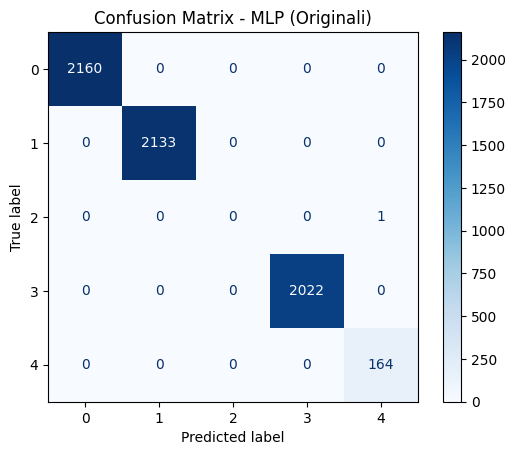

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,100.00,0.00,0.0,0.00,0.0
1,0,0,100.00,0.00,0.0,0.00,0.0
2,1,1,0.00,100.00,0.0,0.00,0.0
3,3,3,0.00,0.00,0.0,100.00,0.0
4,1,1,0.00,99.83,0.0,0.16,0.0
...,...,...,...,...,...,...,...
6475,0,0,100.00,0.00,0.0,0.00,0.0
6476,0,0,100.00,0.00,0.0,0.00,0.0
6477,1,1,0.00,99.99,0.0,0.01,0.0
6478,0,0,100.00,0.00,0.0,0.00,0.0


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.0,0.07,21.69,0.0,78.23


,Training Set,Test Set
Accuracy,0.999846,0.999846
Precision,0.999692,0.999692
Recall,0.999846,0.999846
F1-score,0.999769,0.999769


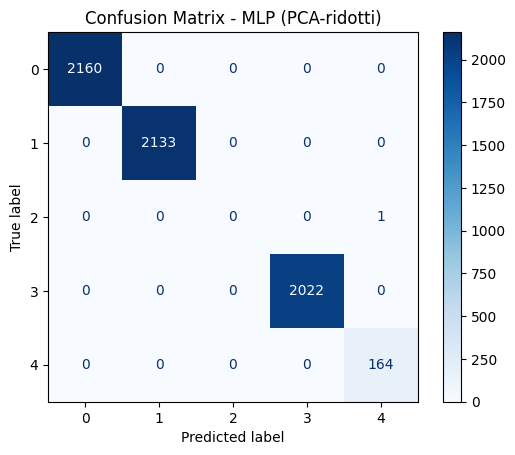

,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,0,100.00,0.00,0.00,0.00,0.00
1,0,0,100.00,0.00,0.00,0.00,0.00
2,1,1,0.00,99.99,0.01,0.00,0.00
3,3,3,0.00,0.00,0.00,100.00,0.00
4,1,1,0.00,99.16,0.00,0.84,0.00
...,...,...,...,...,...,...,...
6475,0,0,100.00,0.00,0.00,0.00,0.00
6476,0,0,100.00,0.00,0.00,0.00,0.00
6477,1,1,0.00,99.98,0.00,0.02,0.00
6478,0,0,100.00,0.00,0.00,0.00,0.00


,True Class,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
4103,2,4,0.0,1.89,3.15,0.0,94.96


In [17]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

[MLP_score, MLP_score_test] = evaluate_and_plot(mlp_model, X_train, y_train, X_test, y_test, name="MLP (Originali)")
[MLP_score_PCA, MLP_score_test_PCA] = evaluate_and_plot(mlp_model, X_train_pca, y_train, X_test_pca, y_test, name="MLP (PCA-ridotti)")

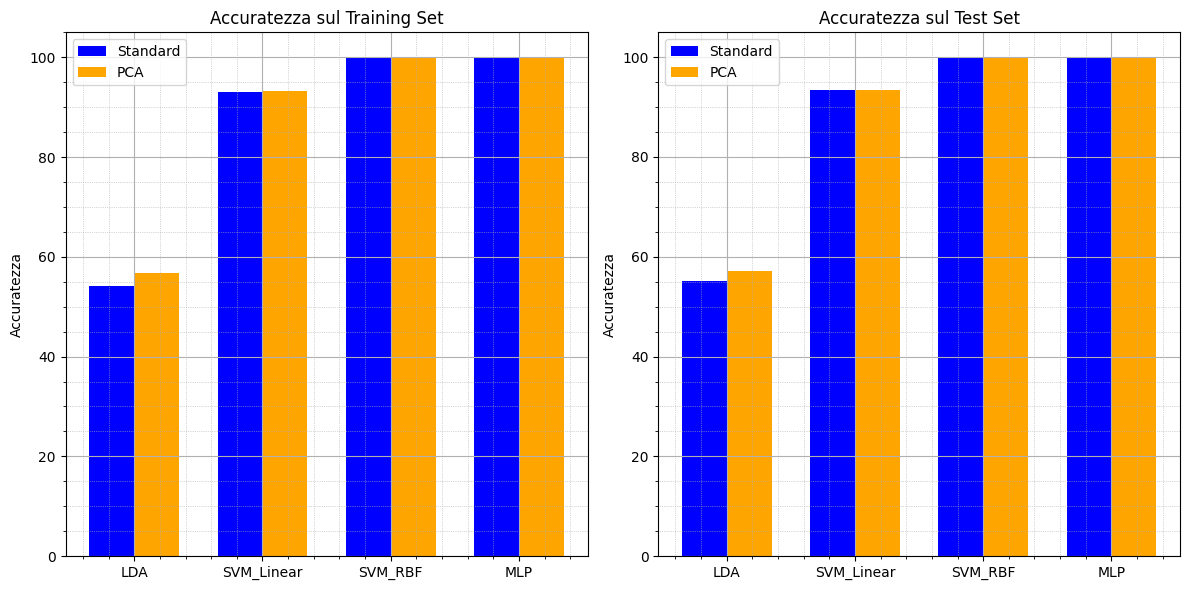

In [18]:
# Etichette raggruppate (senza PCA)
group_labels = ['LDA', 'SVM_Linear', 'SVM_RBF', 'MLP']

# Accuratezze in coppia (modello normale, poi PCA)
actrain = [LDA_score*100, LDA_score_PCA*100,
           SVMl_score*100, SVMl_score_PCA*100,
           SVMnl_score*100, SVMnl_score_PCA*100,
           MLP_score*100, MLP_score_PCA*100]

actest = [LDA_score_test*100, LDA_score_test_PCA*100,
          SVMl_score_test*100, SVMl_score_test_PCA*100,
          SVMnl_score_test*100, SVMnl_score_test_PCA*100,
          MLP_score_test*100, MLP_score_test_PCA*100]

# Colori alternati
colors = ['blue', 'orange'] * 4

x = np.arange(len(group_labels))
width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Training
axs[0].bar(x - width/2, actrain[::2], width, color='blue', label='Standard')
axs[0].bar(x + width/2, actrain[1::2], width, color='orange', label='PCA')
axs[0].set_xticks(x)
axs[0].set_xticklabels(group_labels)
axs[0].set_title('Accuratezza sul Training Set')
axs[0].set_ylabel('Accuratezza')
axs[0].grid(True)
axs[0].minorticks_on()
axs[0].grid(which='minor', linestyle=':', linewidth=0.5)
axs[0].legend()

# Test
axs[1].bar(x - width/2, actest[::2], width, color='blue', label='Standard')
axs[1].bar(x + width/2, actest[1::2], width, color='orange', label='PCA')
axs[1].set_xticks(x)
axs[1].set_xticklabels(group_labels)
axs[1].set_title('Accuratezza sul Test Set')
axs[1].set_ylabel('Accuratezza')
axs[1].grid(True)
axs[1].minorticks_on()
axs[1].grid(which='minor', linestyle=':', linewidth=0.5)
axs[1].legend()

plt.tight_layout()
plt.show()

<p><h3>Comparazione dell'accuracy per percentuali diverse per il training set, PCA al 90%</h3></p>
  <table>
  <tr>
    <td><img src="Images/Tep30.png" alt="Immagine 1" style="width: 300px;"></td>
    <td><img src="Images/Tep50.png" alt="Immagine 2" style="width: 300px;"></td>
    <td><img src="Images/Tep70.png" alt="Immagine 3" style="width: 300px;"></td>
  </tr>
  <tr style="text-align: center; font-style: italic;">
    <td>Train 70%</td>
    <td>Train 50%</td>
    <td>Train 30%</td>
  </tr>
</table>
<li>Durante l’analisi sperimentale, è emerso un comportamento differente tra i dati originali e quelli ridotti tramite PCA rispetto alla variazione della dimensione del training set. In particolare:
    <ul>
      <li>Con i dati originali, l’accuracy dei modelli di classificazione rimane pressoché stabile al variare della percentuale di dati utilizzata per il training. Questo è dovuto al fatto che l’intero spazio informativo è preservato: anche con meno dati, i modelli riescono a cogliere la struttura del problema grazie alla ricchezza e alla completezza delle feature</li>
      <li>Con i dati PCA-ridotti, la dimensione del training set influisce sensibilmente sull’accuratezza dei modelli. Riducendo il numero di componenti, si perde parte dell’informazione originale, e il nuovo spazio proiettivo risulta più compatto e meno interpretabile. In questo contesto, un training set troppo ampio può portare ad overfitting, poiché i modelli tendono ad adattarsi eccessivamente ai pattern indotti dalla trasformazione. Al contrario, una percentuale di training più contenuta favorisce una migliore generalizzazione, migliorando le performance sul test set</li>
    </ul>
  </li>
<p>Questo comportamento evidenzia come la riduzione dimensionale mediante PCA non solo influenzi la struttura dei dati, ma anche la sensibilità degli algoritmi rispetto alla quantità di dati utilizzata in fase di apprendimento. Per questo motivo, è fondamentale bilanciare opportunamente la scelta del numero di componenti con la dimensione del training set, al fine di ottenere prestazioni ottimali.</p>
<p><h3>Comparazione dell'accuracy per percentuali diverse per la PCA, training set al 50%</h3></p>
  <table>
  <tr>
    <td><img src="Images/PCA8T50.png" alt="Immagine 1" style="width: 300px;"></td>
    <td><img src="Images/PCA9T50.png" alt="Immagine 2" style="width: 300px;"></td>
    <td><img src="Images/PCA10T50.png" alt="Immagine 3" style="width: 300px;"></td>
  </tr>
  <tr style="text-align: center; font-style: italic;">
    <td>PCA(14) - 80%</td>
    <td>PCA(17) - 90%</td>
    <td>PCA(19) - 100%</td>
  </tr>
</table>
<p><strong>Confronto dei classificatori rispetto all’uso della PCA</strong></p>
<p>Il <strong>Linear Discriminant Analysis</strong> ha beneficiato fortemente della PCA quando questa è stata applicata con percentuale parziale di varianza, ottenendo un netto miglioramento rispetto all’uso dei dati originali. Tuttavia, con PCA al 100%, che pur mantiene tutta la varianza spiegata ma riduce le dimensioni rispetto ai dati originali, le prestazioni sono drasticamente peggiorate. Questo perché la PCA, pur preservando la varianza globale, non garantisce che le componenti utili alla separazione tra le classi siano tra le prime selezionate</p>
<p><p>Lo <strong>SVM lineare</strong>, invece, si è mostrato robusto alla riduzione dimensionale: le sue prestazioni rimangono elevate anche con PCA(19). Questo comportamento è dovuto alla natura del modello, che cerca un iperpiano di separazione e non è fortemente influenzato dalla distribuzione della varianza, finché le classi restano separabili nello spazio trasformato</p>
</p>
<p>Anche <strong>SVM con kernel RBF</strong> si è comportato bene con la PCA, mantenendo prestazioni alte sia con 27 feature che con PCA al 95–100%. Tuttavia, mostra una leggera sensibilità maggiore rispetto alla versione lineare, poiché la trasformazione non lineare del kernel può essere più influenzata dalla perdita di componenti rilevanti nella fase di riduzione
</p>
<p>Infine, il <strong>MLP</strong> ha mostrato un comportamento simile a SVM RBF. La riduzione dimensionale tramite PCA ha portato a un miglioramento delle prestazioni rispetto ai dati originali, grazie alla semplificazione del problema e alla riduzione del rumore. Le prestazioni si sono mantenute elevate fino alla soglia del 100%, ma tendono a calare se si riducono troppo le componenti. Questo è coerente con la natura delle reti neurali, che richiedono una buona rappresentazione dei dati in input per apprendere correttamente</p>

<p><h3>Differenza fra PCA() e PCA(19)</h3></p>
  <table>
  <tr>
    <td><img src="Images/PCA()TE.png" alt="Immagine 1" style="width: 300px;"></td>
    <td><img src="Images/PCA10T50.png" alt="Immagine 2" style="width: 300px;"></td>
  </tr>
  <tr style="text-align: center; font-style: italic;">
    <td>PCA()</td>
    <td>PCA(19)</td>
  </tr>
</table>
<li>Nel nostro esperimento abbiamo applicato la PCA al dataset per ridurre la dimensionalità e migliorare l’efficienza dei modelli di classificazione. In particolare, abbiamo confrontato due configurazioni:
    <ul>
      <li>PCA(): tutte le 27 componenti principali vengono mantenute. In questo caso, non si ha alcuna riduzione della dimensionalità, ma i dati sono stati trasformati in una nuova base ortogonale</li>
      <li>PCA(19): si mantengono solo le prime 19 componenti principali, che spiegano comunque il 100% della varianza (a causa di ridondanza nei dati originari), ma si riduce la dimensionalità del problema da 27 a 19</li>
    </ul>
  </li>
<p>Nonostante PCA() mantenga lo stesso numero di feature del dataset originale, l’applicazione della PCA migliora drasticamente le performance di LDA. Questo è dovuto al fatto che PCA trasforma il dataset in uno spazio ortogonale, migliorando la condizione numerica per il calcolo della matrice di covarianza e riducendo la dipendenza tra le feature. Di conseguenza, LDA riesce a identificare separazioni tra classi in modo molto più efficace</p>